In [1]:
from pandas import read_csv
from ast import literal_eval
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy import zeros
# from lyapunov_exp import compare_time_series

In [2]:
##########################################
def read_data(part_id, operation_type):
    file_dir = "part"+str(part_id)+"_"+operation_type+"_header.csv"
    raw_df = read_csv(file_dir)
    return raw_df

##########################################
def normalize_list(lst):
    lst_min = min(lst)
    lst_max = max(lst)
    range = lst_max - lst_min
    new_lst = []
    for n in lst:
        new_lst.append((n-lst_min)/range)
    return new_lst

##########################################
def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = zeros((n+1, m+1))
    dtw_matrix[1:, 0] = float('inf')
    dtw_matrix[0, 1:] = float('inf')
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                          dtw_matrix[i, j-1],    # deletion
                                          dtw_matrix[i-1, j-1])  # match
            
    return dtw_matrix[n, m]

##########################################
def moving_mean_filter(data, window_size):
    if not data or window_size <= 0:
        return []
    filtered_data = []
    for i in range(len(data)):
        window = data[max(i - window_size + 1, 0):i + 1]
        filtered_data.append(sum(window) / len(window))
    return filtered_data

In [19]:
def visualize_sim(part_id,task_id,trial_id,section_id,operation_type,smoothing):

    # df = read_data(6, "kt")
    df = read_data(part_id, operation_type)
    df = df[(df['task_id']==task_id) & (df['trial_id']==trial_id) & (df['section']==section_id)]
    df

    inc_trans_list = df['inc_trans'].tolist()
    inc_trans_list = [literal_eval(lst) for lst in inc_trans_list]

    inc_rot_list = df['inc_rot'].tolist()
    inc_rot_list = [literal_eval(lst) for lst in inc_rot_list]

    # look at section 2 for now
    trans_list = inc_trans_list[0]
    rot_list = inc_rot_list[0]

    ##############################################################
    ##############################################################
    
    match smoothing:
        case "moving_mean":
            # apply moving-mean filter
            window_size = 16
            trans_list = moving_mean_filter(trans_list, window_size)
            rot_list = moving_mean_filter(rot_list, window_size)
        case "savgol":
            # apply Savitzky-Golay smoothing filter
            window_size = 32
            poly_order = 3
            trans_list = savgol_filter(trans_list, window_size, poly_order)
            rot_list = savgol_filter(rot_list, window_size, poly_order)
        case _:
            pass    

    # normalize the lists
    trans_list = normalize_list(trans_list)
    rot_list = normalize_list(rot_list)
    diff_list = [trans_list[i] - rot_list[i] for i in range(len(trans_list))]
    
    # compute absolute value of sum of all differences
    abs_diff_list = [abs(val) for val in diff_list]
    abs_diff = sum(abs_diff_list)
    print("Absolution difference sum = %.3f" % abs_diff)

    # # Compute the DTW distance
    # distance = dtw_distance(trans_list, rot_list)
    # # Convert the DTW distance to a similarity score
    # similarity = 1 / (1 + distance)
    # print(f"DTW distance: {distance}")
    # print(f"Similarity score: {similarity}")

    # # compute the Lyapunov exponents
    # lyapunov_ts1, lyapunov_ts2, similarity = compare_time_series(trans_list, rot_list)
    # print(f"Lyapunov exponent of time series 1: {lyapunov_ts1}")
    # print(f"Lyapunov exponent of time series 2: {lyapunov_ts2}")
    # print(f"Similarity between time series: {similarity}")

    # Create a figure and two subplots in a vertical layout
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    # First subplot
    ax1.plot(trans_list, label='translation')
    ax1.set_title('Translation')
    ax1.set_xlabel('time')
    ax1.set_ylabel('translation')
    ax1.legend()
    ax1.grid(True)

    # Second subplot
    ax2.plot(rot_list, label='rotation', color='r')
    ax2.set_title('Rotation')
    ax2.set_xlabel('time')
    ax2.set_ylabel('rotation')
    ax2.legend()
    ax2.grid(True)
    
    # Second subplot
    ax3.plot(diff_list, label='trans - rot', color='g')
    ax3.set_title('Trans - Rot')
    ax3.set_xlabel('time')
    ax3.set_ylabel('Difference')
    ax3.legend()
    ax3.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()

Absolution difference sum = 10.079


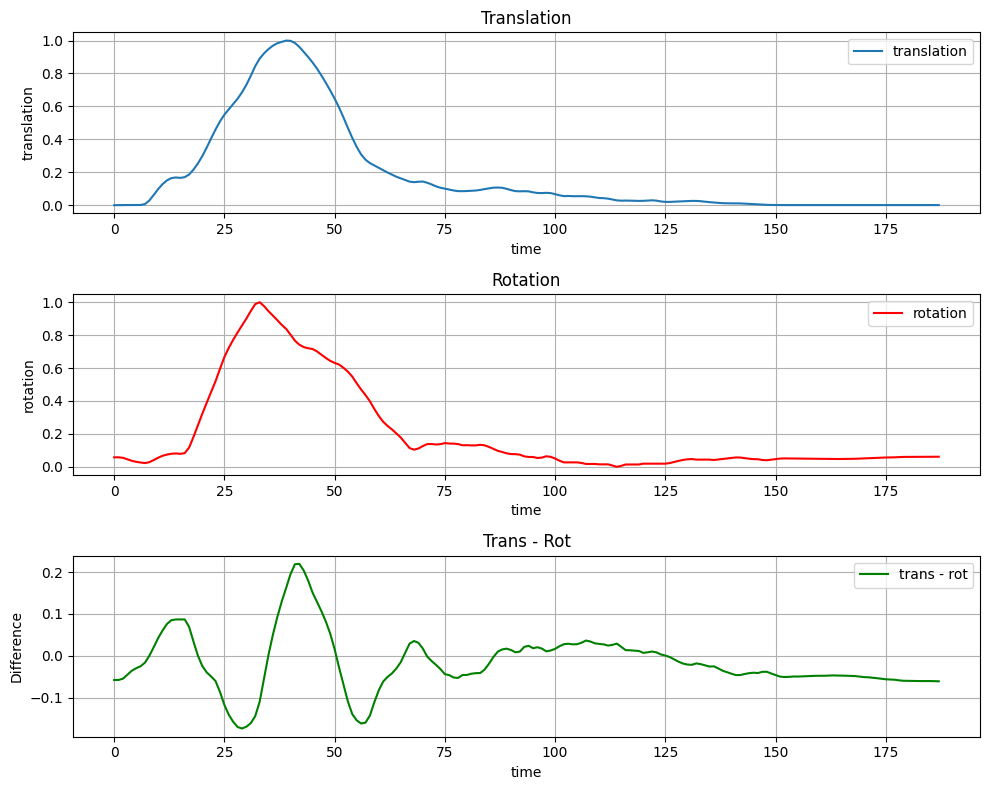

In [27]:
part_id = 6
task_id = 2
trial_id = 1
section_id = 2

operation_type = "kt"
# operation_type = "teleop"

# smoothing_type = "savgol"
smoothing_type = "moving_mean"

visualize_sim(part_id, task_id, trial_id, section_id, operation_type, smoothing_type)